In [46]:
library(IBMPopSim)
library(ggplot2)

In [2]:
#update.packages(checkBuilt=TRUE, ask=FALSE)
#install.packages("Rcpp")
#install.packages("IBMPopSim")
#install.packages("devtools")
#install.packages("IRkernel")
#IRkernel::installspec()

In [3]:
N_init=1
pop_init <- data.frame("birth"=rep(0,N_init), "death"=rep(NA,N_init), "smurfness"=rep(0,N_init))
params <- list("a" = 0.009,
               "t0" = 5.0,
               "k_int" = 0.1911,
               "compet" = 0.000001, 
               "birth_rate" = 0.2,
               "n_immig"= 9)

In [4]:
immig_event <- mk_event_poisson(name="immig1", type = "entry", 
    intensity = 'n_immig', 
    kernel_code = 'newI.set_age(CUnif(0,20),t);
                   newI.smurfness=0;')

In [5]:
death_event <- mk_event_individual(name = "death1", type = "death",
    intensity_code = 'if (I.smurfness==0)
            result = 0;
        else
            result = k_int;'
)

In [6]:
death_event2 <- mk_event_interaction(name = "death2", type = "death", 
    interaction_code = 'result = compet;'
)                                     

In [7]:
birth_event <- mk_event_individual(type="birth",
    intensity_code = 'if (I.smurfness==0)
            result = birth_rate;
        else
            result = birth_rate/15;',
    kernel_code = 'newI.smurfness=0;
                   newI.entry=0;'
)

In [8]:
swap_event <- mk_event_individual(
    type = "swap",
    intensity_code = 'if (I.smurfness==0){
                            if (age(I,t)==0)
                                result = 0;
                            else
                                result = (a*age(I,t)*exp(-t0/age(I,t)));
                            }
                        else
                            result = 0;',
    kernel_code = 'I.smurfness=1;'
)

In [9]:
model <- mk_model(
    characteristics = get_characteristics(pop_init),
    events = list(death_event, death_event2, swap_event, birth_event, immig_event),
    parameters = params,
    with_id = TRUE) #adds individuals IDs

summary(model)

[1] "add 'id' as individual attributes"
[1] "entry event: add 'entry' as individual attributes"
Events:
#1: individual event of type death
#2: interaction event of type death
#3: individual event of type swap
#4: individual event of type birth
#5: poisson event of type entry
--------------------------------------- 
Individual description:
names:  birth death smurfness id entry 
R types:  double double double integer double 
C types:  double double double int double
--------------------------------------- 
R parameters available in C++ code:
names:  a t0 k_int compet birth_rate n_immig 
R types:  double double double double double double 
C types:  double double double double double double

In [10]:
death_max <- params$k_int
swap_max <- params$a*50*exp(-params$t0/50)

In [11]:
t_final = 75
T = 0:t_final # Simulation end time 


sim_out <- popsim(model = model, age_max = 50,
  population = pop_init,
  events_bounds = c('death1'=death_max,'death2'=params$compet, 'swap'= swap_max, 'birth'= params$birth_rate, 'immig1'=params$n_immig),
  parameters = params,
  time = T)

[1] "Add 'id' attributes to the population."


Warning message in popsim(model = model, age_max = 50, population = pop_init, events_bounds = c(death1 = death_max, :
“Add 'entry' attributes to the population.”


Simulation on  [0, 1]  [1, 2]  [2, 3]  [3, 4]  [4, 5]  [5, 6]  [6, 7]  [7, 8]  [8, 9]  [9, 10]  [10, 11]  [11, 12]  [12, 13]  [13, 14]  [14, 15]  [15, 16]  [16, 17]  [17, 18]  [18, 19]  [19, 20]  [20, 21]  [21, 22]  [22, 23]  [23, 24]  [24, 25]  [25, 26]  [26, 27]  [27, 28]  [28, 29]  [29, 30]  [30, 31]  [31, 32]  [32, 33]  [33, 34]  [34, 35]  [35, 36]  [36, 37]  [37, 38]  [38, 39]  [39, 40]  [40, 41]  [41, 42]  [42, 43]  [43, 44]  [44, 45]  [45, 46]  [46, 47]  [47, 48]  [48, 49]  [49, 50]  [50, 51]  [51, 52]  [52, 53]  [53, 54]  [54, 55]  [55, 56]  [56, 57]  [57, 58]  [58, 59]  [59, 60]  [60, 61]  [61, 62]  [62, 63]  [63, 64]  [64, 65]  [65, 66]  [66, 67]  [67, 68]  [68, 69]  [69, 70]  [70, 71]  [71, 72]  [72, 73]  [73, 74]  [74, 75] 

In [12]:
#mortality per age general pop
pop_final <- sim_out$population[[t_final]]
#Dx <- death_table(pop_final, 0:100, 0:100)
#Ex <- exposure_table(pop_final, 0:100, 0:100)
all_dead <- pop_final[is.na(pop_final$death)==FALSE,]
dim(all_dead[all_dead$smurfness==1,])[1]/dim(all_dead)[1]

[1] 0.1013659

In [13]:
dim(pop_final)[1]
dim(all_dead)[1]

[1] 1096728

[1] 915525

In [14]:
taux_smurf_alive<- function(i){pop= sim_out$population[[i]];
                                alive <- pop[is.na(pop$death),]
return(dim(alive[alive$smurfness==1,])[1]/dim(alive)[1]) }
nalive <- function(i){pop= sim_out$population[[i]];
                                alive <- pop[is.na(pop$death),]
return(dim(alive)[1]) }

In [15]:
vec_taux_smurf_alive<- sapply(1:t_final,function(i)(taux_smurf_alive(i)))
N_alive<- sapply(1:t_final,function(i)(nalive(i)))

## age pyramid @ T50

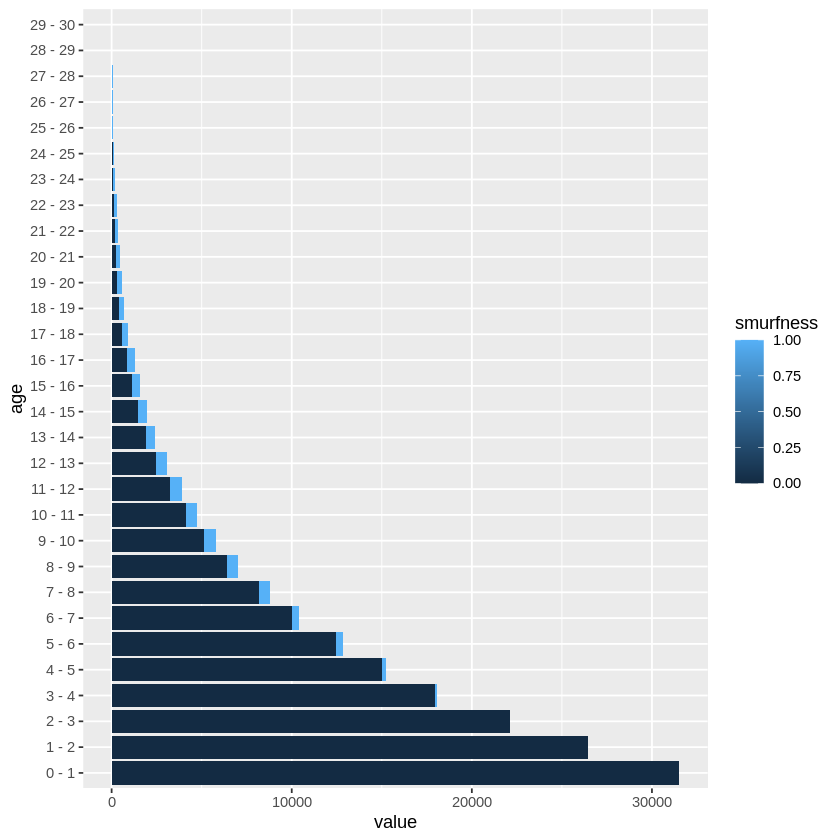

In [50]:
#pyr_init = age_pyramid(sim_out$population[[100]], time = 100,ages = 0:50)
pyr = age_pyramid(sim_out$population[[t_final]], time = t_final, ages=0:30)
#head(pyr)
ggplot(pyr, aes(fill=smurfness, x=value, y=age))+
    geom_bar(position="stack", stat="identity")

## total population size

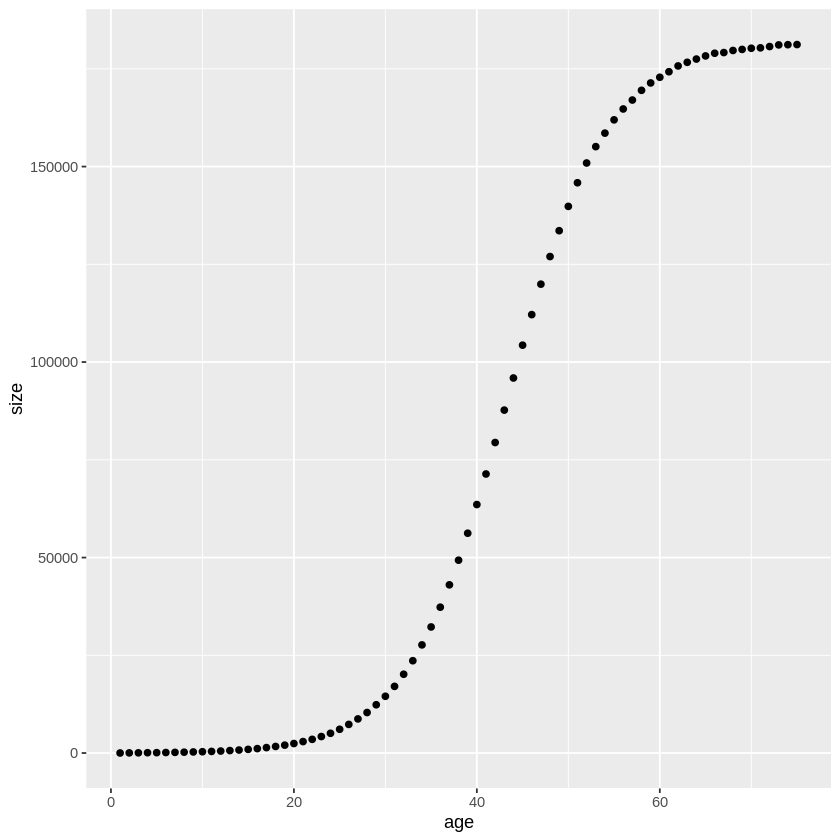

In [55]:
pop_size <- as.data.frame(cbind(1:t_final, N_alive))
colnames(pop_size)<-c("age","size")
ggplot(pop_size)+
    geom_point(aes(x=age, y=size))

## proportion of Smurfs in living pop @ t

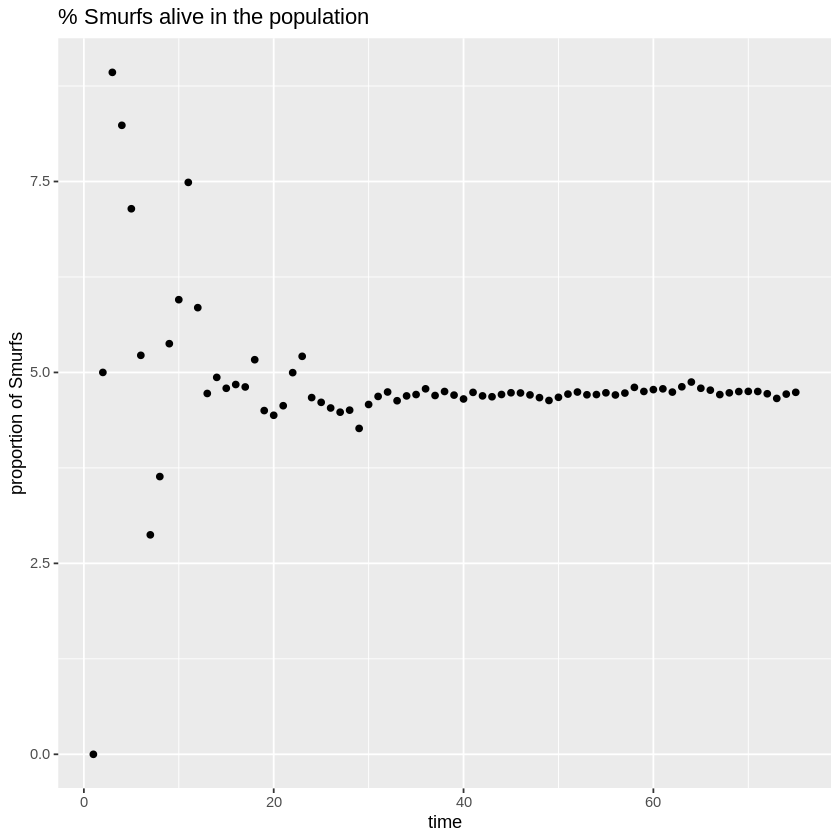

In [61]:
living_smurfs_prop <- as.data.frame(cbind(1:t_final,vec_taux_smurf_alive*100))
colnames(living_smurfs_prop) <- c("time", "prop_smurfs_alive")
ggplot(living_smurfs_prop)+
    geom_point(aes(x=time, y=prop_smurfs_alive))+
    labs(title ="% Smurfs alive in the population", y="proportion of Smurfs", x="time")

## Analyse d'une cohorte

In [19]:
t_cohorte=20
dt_cohorte=1
nb_alive_NS<- c()
nb_alive_S<- c()
for (i in (t_cohorte+dt_cohorte):t_final){
    pop<-sim_out$population[[i]]
nb_alive_NS<-c(nb_alive_NS,  dim(pop[pop$birth>=t_cohorte& pop$birth<t_cohorte+dt_cohorte& is.na(pop$death) & pop$smurfness==0 ,])[1])
nb_alive_S<-c(nb_alive_S,  dim(pop[pop$birth>=t_cohorte& pop$birth<t_cohorte+dt_cohorte& is.na(pop$death) & pop$smurfness==1 ,])[1])  
}

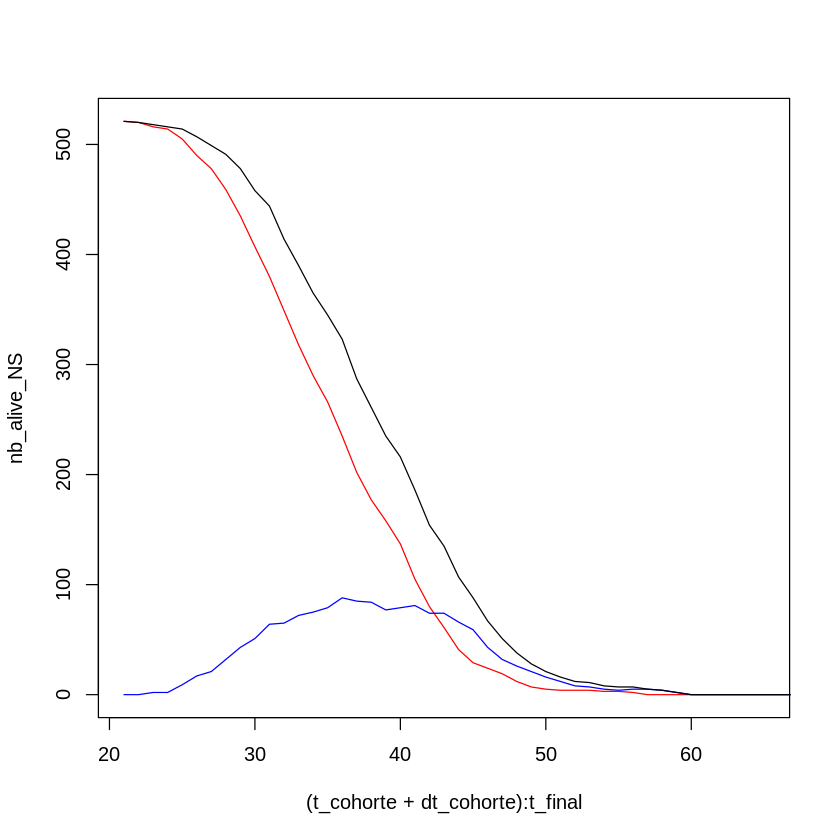

In [20]:
plot((t_cohorte+dt_cohorte):t_final,nb_alive_NS, type='l',col="red", xlim=c(t_cohorte+dt_cohorte,65))
lines((t_cohorte+dt_cohorte):t_final,nb_alive_S, col="blue")
lines((t_cohorte+dt_cohorte):t_final,nb_alive_NS+nb_alive_S)


In [21]:
dim(all_dead[all_dead$entry!=0,])

[1] 671   5

Warning message:
“Removed 10 row(s) containing missing values (geom_path).”
Warning message:
“Removed 10 row(s) containing missing values (geom_path).”
Warning message:
“Removed 10 row(s) containing missing values (geom_path).”


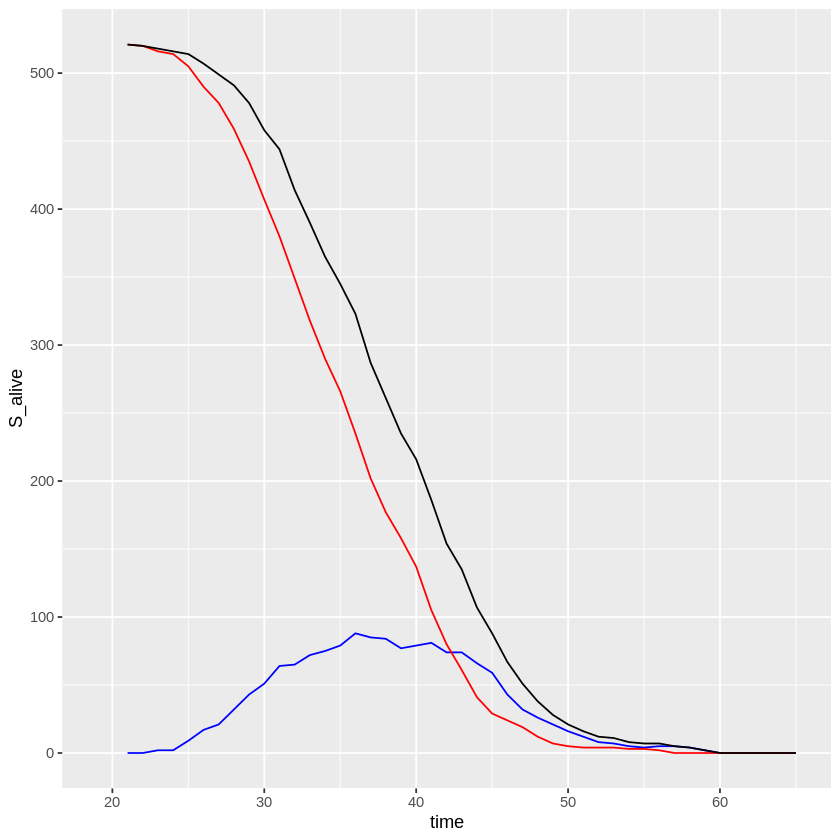

In [77]:
cohort_surv <- as.data.frame(cbind((t_cohorte+dt_cohorte):t_final,nb_alive_NS,nb_alive_S))
colnames(cohort_surv) <- c("time", "NS_alive", "S_alive")
ggplot(cohort_surv, aes(x=time))+
    geom_line(aes(y=S_alive), colour="blue")+
    geom_line(aes(y=NS_alive), colour='red')+
    geom_line(aes(y=NS_alive+S_alive))+
    xlim(19, 65)